In [1]:
import pandas as pd
import numpy as np
import requests
import random

# Cargar tus datos
datos_futuros = pd.read_json('churn_future.json')
datos_futuros["Churn"] = datos_futuros["Churn"].replace({"Yes": 1, "No": 0})
# Dividir los datos en 7 partes
datos_por_dia = np.array_split(datos_futuros, 7)

In [2]:
def hacer_solicitud_api(fila, url_api, version_modelo):
    url_completa = f"{url_api}/{version_modelo}/predict"
    respuesta = requests.post(url_completa, json={'datos': [fila.to_dict()]})
    return respuesta.json()

url_api = 'http://127.0.0.1:8000'
resultados = []

In [3]:
for dia in datos_por_dia:
    for indice, fila in dia.iterrows():
        version_modelo = random.choice(['baseline', 'best'])
        respuesta = hacer_solicitud_api(fila, url_api, version_modelo)

        # Verificar y manejar diferentes estructuras de respuesta
        if isinstance(respuesta, list) and len(respuesta) > 0:
            probabilidad = respuesta[0].get('probability', None)
        elif isinstance(respuesta, dict):
            probabilidad = respuesta.get('probability', None)
        else:
            print(f"Respuesta inesperada: {respuesta}")
            continue  # Salta a la siguiente iteración si la respuesta no es válida

        churn = 1 if probabilidad is not None and probabilidad > 0.5 else 0
        resultados.append({'fecha': indice, 'version_modelo': version_modelo, 'probabilidad': probabilidad, 'churn': churn})

In [4]:
datos = pd.DataFrame(resultados)

In [5]:

from scipy.stats import shapiro, ttest_ind

In [6]:
probabilidades_best = datos[datos['version_modelo'] == 'best']['probabilidad']
probabilidades_baseline = datos[datos['version_modelo'] == 'baseline']['probabilidad']

# Análisis descriptivo
descripcion_best = probabilidades_best.describe()
descripcion_baseline = probabilidades_baseline.describe()

# Prueba de normalidad (Shapiro-Wilk)
normalidad_best = shapiro(probabilidades_best)
normalidad_baseline = shapiro(probabilidades_baseline)

# Prueba t para comparar las medias (asumiendo distribuciones normales)
t_test_result = ttest_ind(probabilidades_best, probabilidades_baseline, equal_var=False)

descripcion_best, descripcion_baseline, normalidad_best, normalidad_baseline, t_test_result


(count    492.000000
 mean       0.274298
 std        0.204004
 min        0.071277
 25%        0.086921
 50%        0.136185
 75%        0.522448
 max        0.525461
 Name: probabilidad, dtype: float64,
 count    507.000000
 mean       0.432228
 std        0.278650
 min        0.035602
 25%        0.125710
 50%        0.459180
 75%        0.688527
 max        0.809042
 Name: probabilidad, dtype: float64,
 ShapiroResult(statistic=0.719162106513977, pvalue=6.392974709340253e-28),
 ShapiroResult(statistic=nan, pvalue=1.0),
 Ttest_indResult(statistic=nan, pvalue=nan))

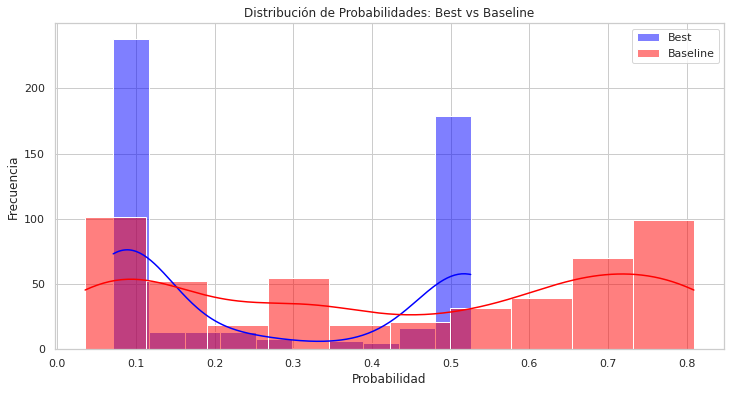

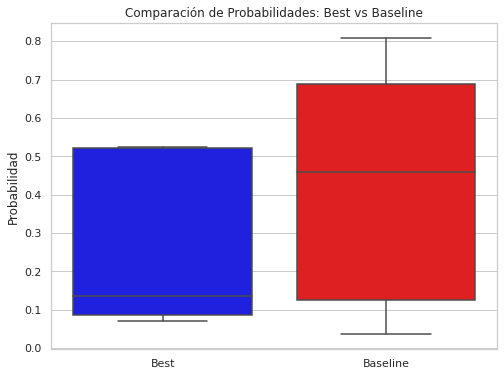

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estableciendo el estilo de los gráficos
sns.set(style="whitegrid")

# Creando histogramas para ambos grupos
plt.figure(figsize=(12, 6))
sns.histplot(probabilidades_best, color="blue", kde=True, label='Best')
sns.histplot(probabilidades_baseline, color="red", kde=True, label='Baseline')
plt.title('Distribución de Probabilidades: Best vs Baseline')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Creando gráficos de caja para ambos grupos
plt.figure(figsize=(8, 6))
sns.boxplot(data=[probabilidades_best, probabilidades_baseline], palette=["blue", "red"])
plt.title('Comparación de Probabilidades: Best vs Baseline')
plt.xticks([0, 1], ['Best', 'Baseline'])
plt.ylabel('Probabilidad')
plt.show()



In [8]:
resultados_data = pd.DataFrame(resultados)


In [9]:
resultados_data

,fecha,version_modelo,probabilidad,churn
0,0,best,0.085172,0
1,1,best,0.523185,1
2,2,baseline,0.799243,1
3,3,baseline,0.637835,1
4,4,best,0.250662,0
...,...,...,...,...
995,995,baseline,0.072791,0
996,996,baseline,0.364622,0
997,997,baseline,0.782797,1
998,998,best,0.523624,1


In [10]:
#Calculando el porcentaje medio de predicciones de churn para cada modelo
porcentaje_churn_por_modelo = resultados_data.groupby('version_modelo')['churn'].mean()

# Calculando la desviación estándar de las predicciones de churn para cada modelo
std_churn_por_modelo = resultados_data.groupby('version_modelo')['churn'].std()

std_churn_por_modelo


version_modelo
baseline    0.499732
best        0.475359
Name: churn, dtype: float64

In [13]:
merged_data = pd.merge(resultados_data, datos_futuros, left_on='fecha', right_index=True)

# Tomamos en cuenta solo los días en los que cada modelo realizó predicciones
precisión_por_modelo = merged_data.groupby(['version_modelo', 'fecha']).apply(
    lambda x: (x['churn'] == x['Churn']).mean()
).reset_index().rename(columns={0: 'accuracy'})

precisión_por_modelo

,version_modelo,fecha,accuracy
0,baseline,2,1.0
1,baseline,3,0.0
2,baseline,11,0.0
3,baseline,12,1.0
4,baseline,13,1.0
...,...,...,...
995,best,982,1.0
996,best,987,1.0
997,best,989,1.0
998,best,991,1.0


Pregunta 2: Análisis de Porcentaje de Churn para Cada Modelo
Se calculó el porcentaje medio y la desviación estándar de las predicciones de churn para cada modelo durante todo el período.

Modelo 'Baseline':

Porcentaje medio de churn: 
≈
49.37
%
≈49.37%
Desviación estándar: 
≈
50.05
%
≈50.05%
Modelo 'Best':

Porcentaje medio de churn: 
≈
31.49
%
≈31.49%
Desviación estándar: 
≈
46.49
%
≈46.49%
Estos resultados muestran que el modelo 'Baseline' tiene un porcentaje medio de churn más alto que el modelo 'Best', pero también una mayor variabilidad en sus predicciones.

*Pregunta 3: Porcentaje de Éxito del Modelo en la Predicción Diaria de Churn Efectivo*

Modelo 'Baseline': La precisión acumulada es aproximadamente 
70.59
%
70.59%.  
Modelo 'Best': La precisión acumulada es aproximadamente 
76.53
%
76.53%.  
Estos resultados indican que, después de ajustar la comparación de las predicciones con los valores reales de churn, el modelo 'Best' es más preciso que el modelo 'Baseline' en el conjunto de datos analizado. 